https://www.kaggle.com/code/toshikazuwatanabe/dgl-graph-classification-sample/notebook

# - 概要：DGLのグラフ分類サンプルの写経。
- 目的：dglとdgl.batchの使い方を把握する
- わかったこと：dgl.batchを使うことでノード数、エッジ数の異なる複数のグラフを入力としたgraph classificationができる
- 応用したいこと：ノード数の異なる複数のグラフを入力に各ノードの属性を予測させるnode classification
- reference: https://docs.dgl.ai/en/0.6.x/tutorials/basics/4_batch.html

> To train neural networks efficiently, a common practice is to batch multiple samples together to form a mini-batch. Batching fixed-shaped tensor inputs is common. For example, batching two images of size 28 x 28 gives a tensor of shape 2 x 28 x 28. By contrast, batching graph inputs has two challenges:
> - Graphs are sparse.
> -Graphs can have various length. For example, number of nodes and edges.
>
> To address this, DGL provides a `dgl.batch()` API. It leverages the idea that a batch of graphs can be viewed as a large graph that has many disjointed connected components. Below is a visualization that gives the general idea.

# Install DGL

In [1]:
#!conda install -q -y -c dglteam dgl

# Import

In [1]:
import os
os.environ['DGLBACKEND'] = 'pytorch'

In [2]:
import dgl
import torch
import dgl.data
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx

from dgl.nn.pytorch import GraphConv

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from dgl.dataloading import GraphDataLoader

# Load toy dataset
> In this tutorial, you learn how to perform batched graph classification with DGL. The example task objective is to classify eight types of topologies shown here.
> 
> https://data.dgl.ai/tutorial/batch/dataset_overview.png
> 
> Implement a synthetic dataset data.MiniGCDataset in DGL. The dataset has eight different types of graphs and each class has the same number of graph samples.

In [4]:
# A dataset with 80 samples, each graph is
# of size [10, 20]
dataset = MiniGCDataset(80, 10, 20)

## Quick look at the Dataset

In [5]:
dataset

Dataset("minigc", num_graphs=80, save_path=/home/uwamichi/.dgl/minigc)

In [6]:
# dir(dataset)

`dgl.data`のインスタンスには配列っぽいアクセスができる様子

In [7]:
len(dataset)

80

このdatasetの場合、(グラフ クラス)のtupleが入っている

In [8]:
dataset[0]

(Graph(num_nodes=15, num_edges=45,
       ndata_schemes={}
       edata_schemes={}),
 tensor(0))

０番目のグラフを表示してみる

(Graph(num_nodes=15, num_edges=45,
      ndata_schemes={}
      edata_schemes={}), tensor(0))


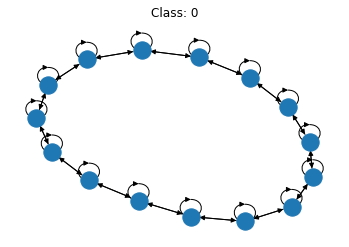

In [9]:
def plot_data(n):
    print(dataset[n])
    graph, label = dataset[n]
    fig, ax = plt.subplots()
    nx.draw(graph.to_networkx(), ax=ax)
    ax.set_title('Class: {:d}'.format(label))
    plt.show()
    
plot_data(0)

(Graph(num_nodes=17, num_edges=49,
      ndata_schemes={}
      edata_schemes={}), tensor(1))


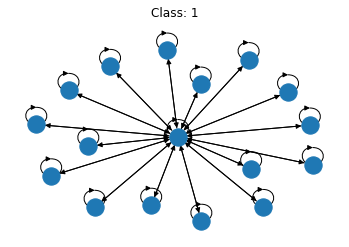

In [10]:
#10番目
plot_data(10)

(Graph(num_nodes=15, num_edges=71,
      ndata_schemes={}
      edata_schemes={}), tensor(2))


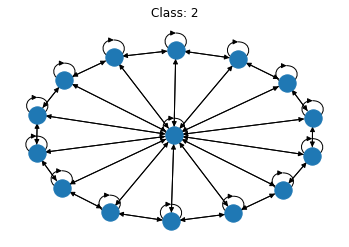

In [11]:
#20番目
plot_data(20)

## わかったこと
- このデータは8種類の形状が異なる80個のグラフを含んでいるデータ
- このタスクはそれぞれのグラフの種類を予測させるタスク
- 各グラフはノード数、エッジ数が異なっているグラフ
- おそらくdataset[9:0]はclass=0, [19:10]はclass=1のデータという感じになっている->要shaffle

# Data loader

In [12]:
# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)

In [41]:
# Use DGL's GraphDataLoader. It by default handles the
# graph batching operation for every mini-batch.
data_loader = GraphDataLoader(trainset, batch_size=32, shuffle=True)

In [3]:
def plot_graph(graph, figsize=None):
    print(graph)
    if figsize is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = plt.subplots(figsize=figsize)
    nx.draw(graph.to_networkx(), ax=ax)
    plt.show()
    
plot_graph(trainset[0][0], [18,16])

NameError: name 'trainset' is not defined

tensor([7, 0, 1, 7, 2, 7, 5, 6, 3, 2, 6, 2, 1, 5, 4, 4, 4, 1, 7, 5, 6, 3, 2, 5,
        2, 1, 6, 4, 7, 1, 5, 1])
Graph(num_nodes=438, num_edges=2430,
      ndata_schemes={}
      edata_schemes={})


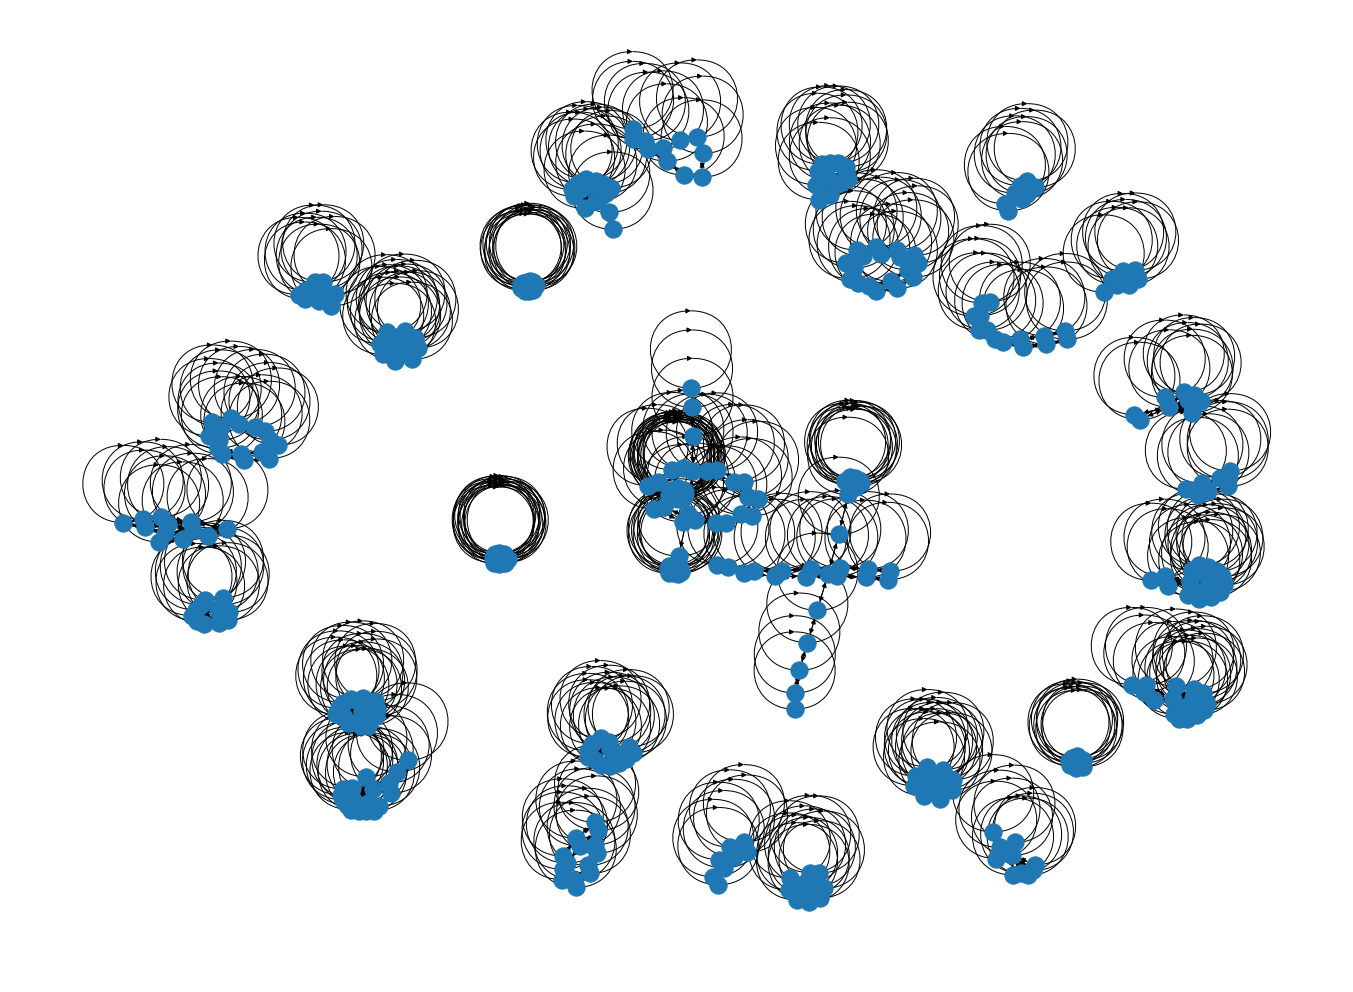

Graph(num_nodes=18, num_edges=72,
      ndata_schemes={}
      edata_schemes={})


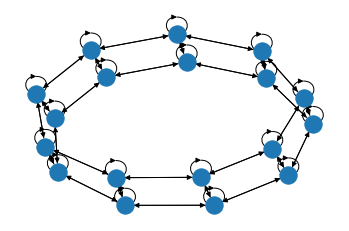

Graph(num_nodes=11, num_edges=33,
      ndata_schemes={}
      edata_schemes={})


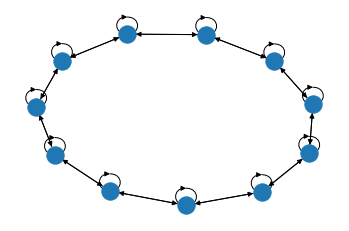

Graph(num_nodes=10, num_edges=28,
      ndata_schemes={}
      edata_schemes={})


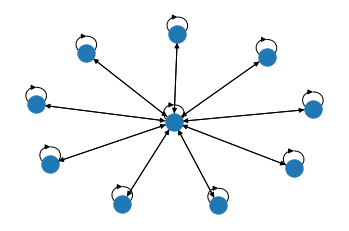

Graph(num_nodes=16, num_edges=64,
      ndata_schemes={}
      edata_schemes={})


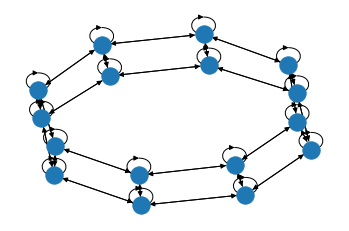

Graph(num_nodes=12, num_edges=56,
      ndata_schemes={}
      edata_schemes={})


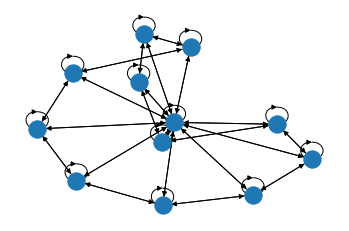

Graph(num_nodes=18, num_edges=72,
      ndata_schemes={}
      edata_schemes={})


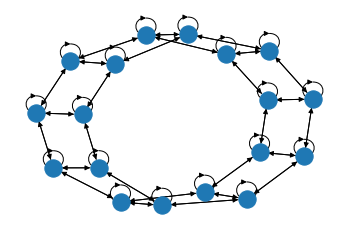

Graph(num_nodes=12, num_edges=46,
      ndata_schemes={}
      edata_schemes={})


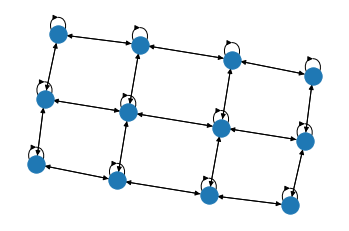

Graph(num_nodes=17, num_edges=289,
      ndata_schemes={}
      edata_schemes={})


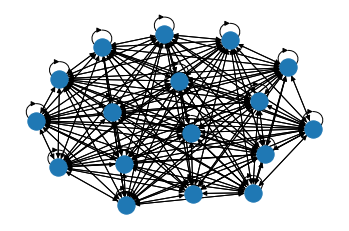

Graph(num_nodes=16, num_edges=136,
      ndata_schemes={}
      edata_schemes={})


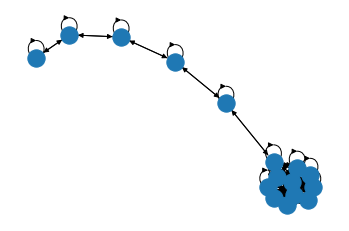

Graph(num_nodes=12, num_edges=56,
      ndata_schemes={}
      edata_schemes={})


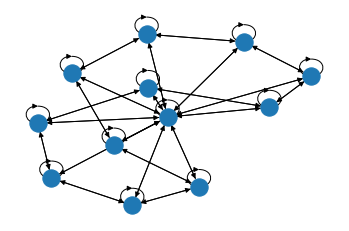

Graph(num_nodes=13, num_edges=169,
      ndata_schemes={}
      edata_schemes={})


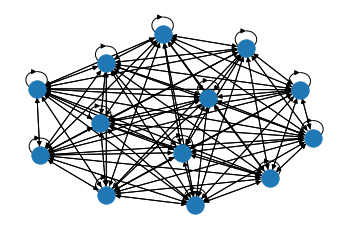

Graph(num_nodes=12, num_edges=56,
      ndata_schemes={}
      edata_schemes={})


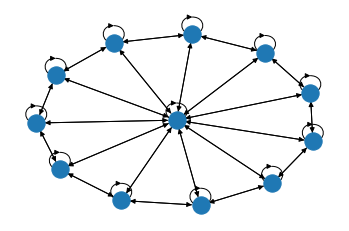

Graph(num_nodes=10, num_edges=28,
      ndata_schemes={}
      edata_schemes={})


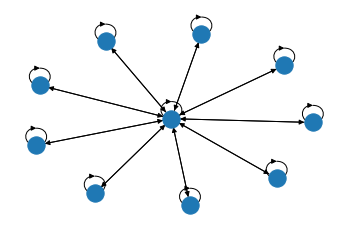

Graph(num_nodes=8, num_edges=28,
      ndata_schemes={}
      edata_schemes={})


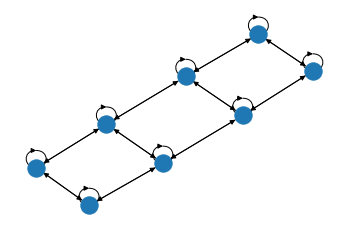

Graph(num_nodes=16, num_edges=80,
      ndata_schemes={}
      edata_schemes={})


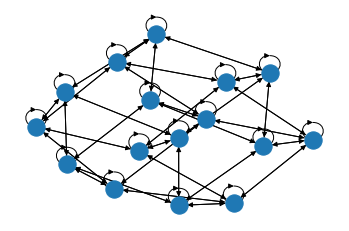

Graph(num_nodes=8, num_edges=32,
      ndata_schemes={}
      edata_schemes={})


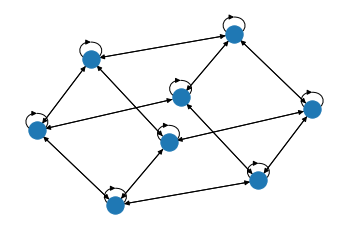

Graph(num_nodes=8, num_edges=32,
      ndata_schemes={}
      edata_schemes={})


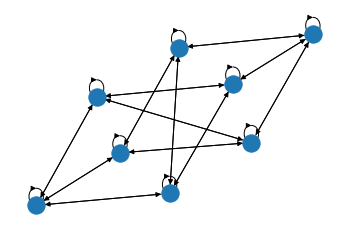

Graph(num_nodes=19, num_edges=55,
      ndata_schemes={}
      edata_schemes={})


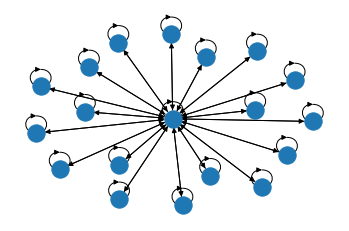

Graph(num_nodes=14, num_edges=56,
      ndata_schemes={}
      edata_schemes={})


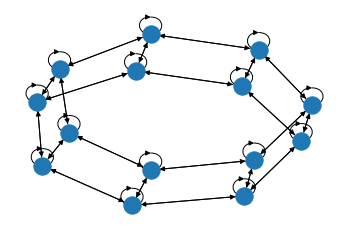

Graph(num_nodes=14, num_edges=52,
      ndata_schemes={}
      edata_schemes={})


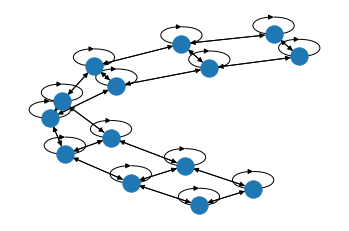

Graph(num_nodes=10, num_edges=100,
      ndata_schemes={}
      edata_schemes={})


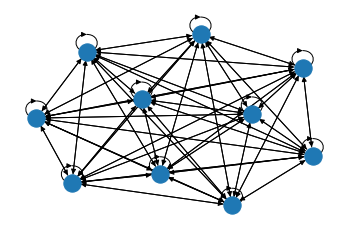

Graph(num_nodes=18, num_edges=142,
      ndata_schemes={}
      edata_schemes={})


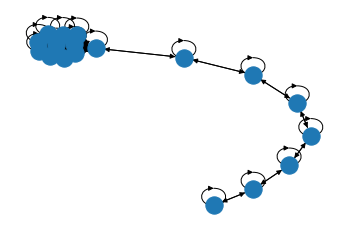

Graph(num_nodes=15, num_edges=71,
      ndata_schemes={}
      edata_schemes={})


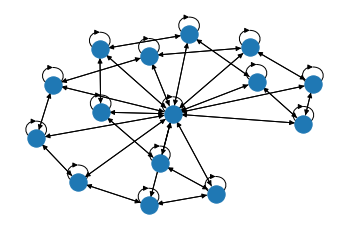

Graph(num_nodes=8, num_edges=28,
      ndata_schemes={}
      edata_schemes={})


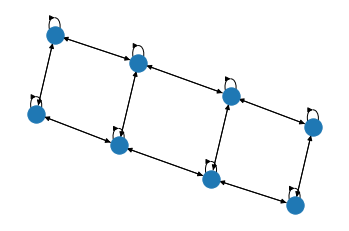

Graph(num_nodes=15, num_edges=71,
      ndata_schemes={}
      edata_schemes={})


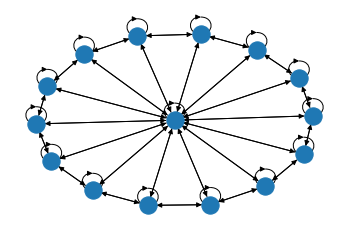

Graph(num_nodes=19, num_edges=55,
      ndata_schemes={}
      edata_schemes={})


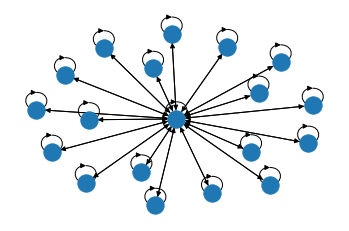

Graph(num_nodes=16, num_edges=256,
      ndata_schemes={}
      edata_schemes={})


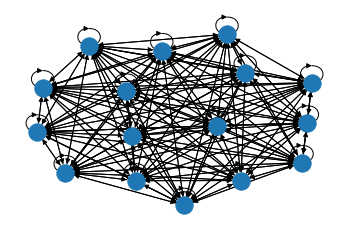

Graph(num_nodes=16, num_edges=80,
      ndata_schemes={}
      edata_schemes={})


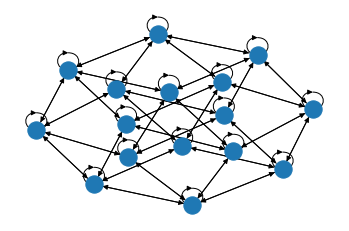

Graph(num_nodes=10, num_edges=40,
      ndata_schemes={}
      edata_schemes={})


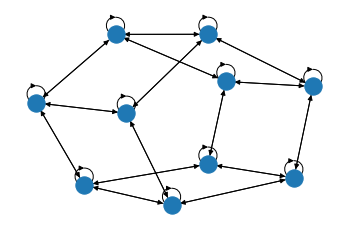

Graph(num_nodes=14, num_edges=40,
      ndata_schemes={}
      edata_schemes={})


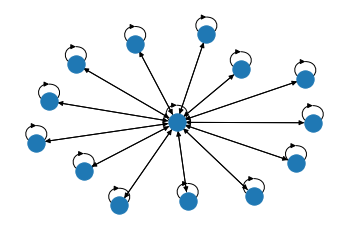

Graph(num_nodes=14, num_edges=52,
      ndata_schemes={}
      edata_schemes={})


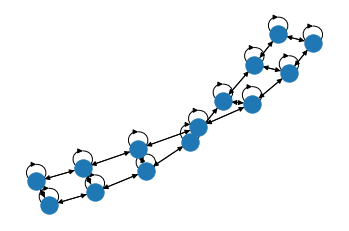

Graph(num_nodes=19, num_edges=55,
      ndata_schemes={}
      edata_schemes={})


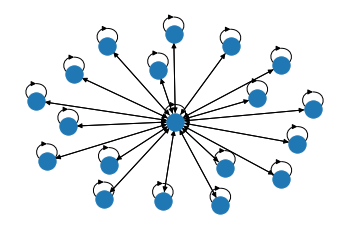

In [44]:
Iter = iter(data_loader)

for i in range(1):
    bg, label = next(Iter)
    print(label)
    plot_graph(bg, [24,18])
    gg = dgl.unbatch(bg)
    for g in gg:
        plot_graph(g)

In [47]:
print(len(gg))
print(label.size())

32
torch.Size([32])


33
Graph(num_nodes=10, num_edges=1,
      ndata_schemes={}
      edata_schemes={})


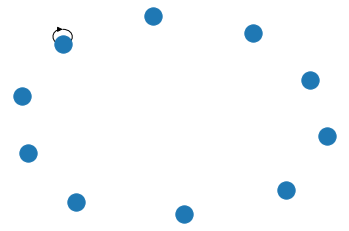

In [58]:
test_edge  = torch.tensor([1], dtype=torch.int64)
test_graph = dgl.graph(('coo', (test_edge, test_edge)), num_nodes=10)
bbg = dgl.batch([test_graph, bg])
gg2 = dgl.unbatch(bbg)
print(len(gg2))
plot_graph(gg2[0])

# Model

In [14]:
class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

In [15]:
# Create model
model = Classifier(1, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

Classifier(
  (conv1): GraphConv(in=1, out=256, normalization=both, activation=None)
  (conv2): GraphConv(in=256, out=256, normalization=both, activation=None)
  (classify): Linear(in_features=256, out_features=8, bias=True)
)

# Train

In [16]:
epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 0, loss 2.0012
Epoch 1, loss 1.9676
Epoch 2, loss 1.9592
Epoch 3, loss 1.9462
Epoch 4, loss 1.9342
Epoch 5, loss 1.9223
Epoch 6, loss 1.9060
Epoch 7, loss 1.8870
Epoch 8, loss 1.8664
Epoch 9, loss 1.8263
Epoch 10, loss 1.7819
Epoch 11, loss 1.7271
Epoch 12, loss 1.6696
Epoch 13, loss 1.6081
Epoch 14, loss 1.5392
Epoch 15, loss 1.4788
Epoch 16, loss 1.4167
Epoch 17, loss 1.3557
Epoch 18, loss 1.3067
Epoch 19, loss 1.2436
Epoch 20, loss 1.1931
Epoch 21, loss 1.1311
Epoch 22, loss 1.1018
Epoch 23, loss 1.0636
Epoch 24, loss 1.0312
Epoch 25, loss 1.0111
Epoch 26, loss 0.9846
Epoch 27, loss 0.9497
Epoch 28, loss 0.9267
Epoch 29, loss 0.9239
Epoch 30, loss 0.8858
Epoch 31, loss 0.8843
Epoch 32, loss 0.8620
Epoch 33, loss 0.8876
Epoch 34, loss 0.8453
Epoch 35, loss 0.8263
Epoch 36, loss 0.8324
Epoch 37, loss 0.8532
Epoch 38, loss 0.8461
Epoch 39, loss 0.8192
Epoch 40, loss 0.7957
Epoch 41, loss 0.7770
Epoch 42, loss 0.7697
Epoch 43, loss 0.7640
Epoch 44, loss 0.7630
Epoch 45, loss 0.763

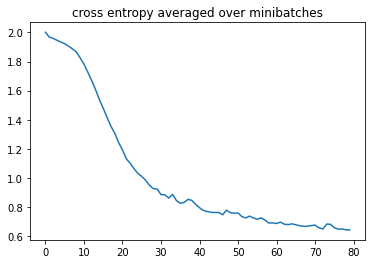

In [17]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

# Test

In [18]:
# modelを推論モードに切り替え
model.eval()

Classifier(
  (conv1): GraphConv(in=1, out=256, normalization=both, activation=None)
  (conv2): GraphConv(in=256, out=256, normalization=both, activation=None)
  (classify): Linear(in_features=256, out_features=8, bias=True)
)

In [19]:
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))

In [20]:
# test_Xは学習には使っていないテスト用のグラフが80個入っているリスト
test_X

[Graph(num_nodes=15, num_edges=45,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=10, num_edges=30,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=13, num_edges=39,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=13, num_edges=39,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=17, num_edges=51,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=19, num_edges=57,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=13, num_edges=39,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=15, num_edges=45,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=12, num_edges=36,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=14, num_edges=42,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=17, num_edges=49,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=16, num_edges=46,
       ndata_schemes={}
      

In [21]:
# test_Yは正解クラスが80個入っているリスト
test_Y

[tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(3),
 tensor(3),
 tensor(3),
 tensor(3),
 tensor(3),
 tensor(3),
 tensor(3),
 tensor(3),
 tensor(3),
 tensor(3),
 tensor(4),
 tensor(4),
 tensor(4),
 tensor(4),
 tensor(4),
 tensor(4),
 tensor(4),
 tensor(4),
 tensor(4),
 tensor(4),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(6),
 tensor(6),
 tensor(6),
 tensor(6),
 tensor(6),
 tensor(6),
 tensor(6),
 tensor(6),
 tensor(6),
 tensor(6),
 tensor(7),
 tensor(7),
 tensor(7),
 tensor(7),
 tensor(7),
 tensor(7),
 tensor(7),
 tensor(7),
 tensor(7),
 tensor(7)]

In [22]:
# テスト用のグラフのリストを`dgl.batch`でまとめる
test_bg = dgl.batch(test_X)

In [23]:
# テスト用の正解が入っている要素数=80のリストをtorch.Tensor;size=(80,1)に変換する
test_Y = torch.tensor(test_Y).float().view(-1, 1)
test_Y.shape

torch.Size([80, 1])

In [24]:
# 推論させるにはモデルに`dgl.batch`でまとめたグラフを入力する
pred = model(test_bg)

In [25]:
# 各グラフ x 8クラスの予測値が返る
pred.shape

torch.Size([80, 8])

In [26]:
# softmaxで各グラフ x 8クラスの確率分布に変換
probs_Y = torch.softmax(pred, 1)
probs_Y.shape

torch.Size([80, 8])

In [27]:
# ここわかんない
sampled_Y = torch.multinomial(probs_Y, 1)
# sampled_Y

In [28]:
# なぜtorch.argmaxじゃないんだろう
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
# argmax_Y

In [29]:
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 65.0000%
Accuracy of argmax predictions on the test set: 70.000000%


# Other Dataset

In [6]:
otherDataset = dgl.data.PPIDataset()
print(otherDataset[0])
print(otherDataset[1])
print(otherDataset.__len__())
#plot_graph(otherDataset[0])

Graph(num_nodes=1767, num_edges=34085,
      ndata_schemes={'label': Scheme(shape=(121,), dtype=torch.float32), 'feat': Scheme(shape=(50,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})
Graph(num_nodes=1377, num_edges=31081,
      ndata_schemes={'label': Scheme(shape=(121,), dtype=torch.float32), 'feat': Scheme(shape=(50,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})
20


In [8]:
other_loader = GraphDataLoader(otherDataset, batch_size=5, shuffle=True)

In [9]:
Iter = iter(other_loader)

for i in range(1):
    bg = next(Iter)
    print(bg)
    #plot_graph(bg, [24,18])
    gg = dgl.unbatch(bg)
    for g in gg:
        print(g)
        #plot_graph(g)

Graph(num_nodes=13160, num_edges=395528,
      ndata_schemes={'label': Scheme(shape=(121,), dtype=torch.float32), 'feat': Scheme(shape=(50,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})
Graph(num_nodes=3021, num_edges=94359,
      ndata_schemes={'label': Scheme(shape=(121,), dtype=torch.float32), 'feat': Scheme(shape=(50,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})
Graph(num_nodes=1021, num_edges=19237,
      ndata_schemes={'label': Scheme(shape=(121,), dtype=torch.float32), 'feat': Scheme(shape=(50,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})
Graph(num_nodes=3480, num_edges=110234,
      ndata_schemes={'label': Scheme(shape=(121,), dtype=torch.float32), 'feat': Scheme(shape=(50,), dtype=torch.float32), '_ID': Scheme(shape